In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from NumpyNN.NN_np import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer,
    CrossEntropyLossWithSoftMax,
    softmax,
    Conv2d,
    Flatten
)

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

In [4]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [5]:
y_train.shape, X_train.shape

((60000, 10), (60000, 1, 28, 28))

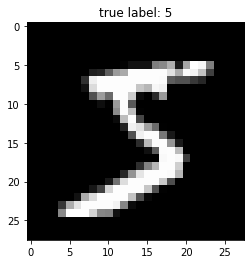

In [6]:
plt.title(f"true label: {np.argmax(y_train[0])}")
plt.imshow(X_train[0].reshape(28, 28))

In [7]:
# in history we metrics for batches in the implementation below
"""
mean_trainable_layers = []

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):
    global mean_trainable_layers
    mean_trainable_layers = []
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model.forward(X_b_train)
            loss_val = loss.forward(y_pred, y_b_train)
            loss_gradient = loss.backward()
            model.backward(loss_gradient)
            optimizer.step()

            y_pred_label = np.argmax(y_pred, axis=1)
            y_true_label = np.argmax(y_b_train, axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label))
            history['train']['loss'].append(loss_val)
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro'))

            wd = [
                np.mean([np.mean(layer.weights) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights) for layer in model.trainable_layers]),
                np.mean([np.mean(layer.weights_gradient) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights_gradient) for layer in model.trainable_layers])
            ]
            weights_data.append(wd)

            uniq_gradient_vals = list(set(abs(model.trainable_layers[0].weights_gradient.flatten())))
            mean_trainable_layers.append(np.mean(uniq_gradient_vals))

    return history
"""
None

In [8]:
def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):

    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}
    #history['train']['y_pred_labels'] = []
    #history['train']['y_true_labels'] = []
    history['train']['mean_trainable_layers'] = []
    history['train']['weights_data'] = []
    for i in tqdm(range(epochs)):
        y_pred_labels = []
        y_true_labels = []
        epoch_loss = 0
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model.forward(X_b_train)
            loss_val = loss.forward(y_pred, y_b_train)
            loss_gradient = loss.backward()
            model.backward(loss_gradient)
            optimizer.step()

            y_pred_label_b = np.argmax(y_pred, axis=1)
            y_true_label_b = np.argmax(y_b_train, axis=1)


            epoch_loss += loss_val.item()
            y_pred_labels.extend(y_pred_label_b)
            y_true_labels.extend(y_true_label_b)

            wd = [
                np.mean([np.mean(layer.weights) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights) for layer in model.trainable_layers]),
                np.mean([np.mean(layer.weights_gradient) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights_gradient) for layer in model.trainable_layers])
            ]
            history['train']['weights_data'].append(wd)

            uniq_gradient_vals = list(set(abs(model.trainable_layers[0].weights_gradient.flatten())))
            history['train']['mean_trainable_layers'].append(np.mean(uniq_gradient_vals))
        
        #history['train']['y_pred_labels'].append(y_pred_labels)
        #history['train']['y_true_labels'].append(y_true_labels)
        history['train']['accuracy'].append(np.mean(np.array(y_pred_labels) == np.array(y_true_labels)))
        history['train']['loss'].append(loss_val)
        history['train']['f1_score'].append(f1_score(y_pred_labels, y_true_labels, average='macro'))

    return history

In [9]:
in_channels = 1
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True

height = X_train[0].shape[1]
width = X_train[0].shape[2]

batch_size = 1024
epochs = 1
weights_data = []

model = Sequential([
    Conv2d(in_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    # Conv2d(out_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    Flatten(), FullyConnectedLayer(height * width * out_channels, 10)])
# optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
loss = CrossEntropyLossWithSoftMax()

history = train(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]

(1024, 25088) (1024, 32, 28, 28)
(1024, 25088) (1024, 32, 28, 28)


  0%|          | 0/1 [10:02<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\SystemPoint\AppData\Local\Temp\ipykernel_11216\1403117211.py", line 23, in <cell line: 23>
    history = train(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size)
  File "C:\Users\SystemPoint\AppData\Local\Temp\ipykernel_11216\3807656957.py", line 21, in train
    model.backward(loss_gradient)
  File "c:\Users\SystemPoint\Documents\DNN_course_ITMO_2022\lab1\numpy_CNN\NumpyNN\NN_np.py", line 368, in backward
    return output_gradient
  File "c:\Users\SystemPoint\Documents\DNN_course_ITMO_2022\lab1\numpy_CNN\NumpyNN\NN_np.py", line -1, in backward
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\SystemPoint\AppData\Local\Prog

In [ ]:
"""
history2 = train(model, X_train, y_train, X_test, y_test, optimizer, loss, 20, batch_size)
for key in history['train']:
    history['train'][key].extend(history2['train'][key])
"""

In [ ]:
a = list(set(abs(model.trainable_layers[1].weights_gradient.flatten())))
np.mean(a)

0.004558448189276543

In [ ]:
np.abs(model.trainable_layers[0].weights_gradient.flatten()).mean()

0.18528132027444824

In [10]:
for key, value in history['train'].items():
    if key in ['weights_data', 'mean_trainable_layers']:
        continue
    plt.plot(value)
    plt.title(key)
    plt.show()

NameError: name 'history' is not defined

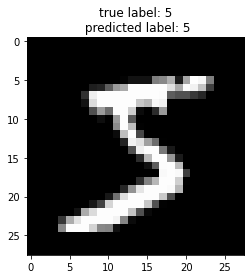

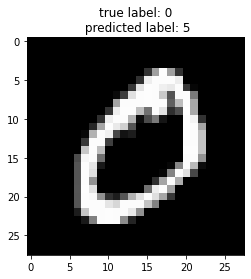

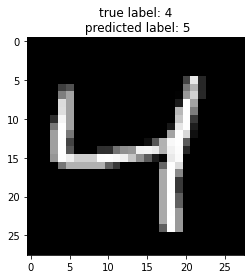

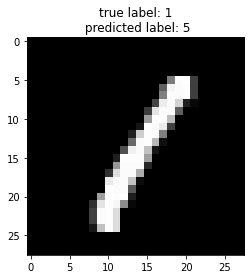

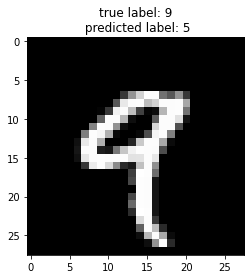

In [12]:
for i in range(5):
    probs_i = softmax(model.forward(X_train[i].reshape(1, 1, 28, 28)))
    plt.title(f"true label: {np.argmax(y_train[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_train[i].reshape(28, 28))
    plt.show()

In [ ]:
"""
def train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):
    for epoch in range(epochs):
        for X_batch, y_batch in get_batches(X, y, batch_size):
            y_pred = model.forward(X_batch)
            loss_gradient = loss.gradient(y_batch, y_pred)
            model.backward(loss_gradient)
            optimizer.step()
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")
"""

'\ndef train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):\n    for epoch in range(epochs):\n        for X_batch, y_batch in get_batches(X, y, batch_size):\n            y_pred = model.forward(X_batch)\n            loss_gradient = loss.gradient(y_batch, y_pred)\n            model.backward(loss_gradient)\n            optimizer.step()\n        if verbose:\n            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")\n'

In [ ]:
import torch

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model(X_b_train)
            loss_val = loss(y_pred, y_b_train)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
            y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())
            
    return history

In [ ]:
np.argmax([[1, 2, 3], [4, 5, 6]], axis = 0)

array([1, 1, 1], dtype=int64)

In [ ]:
X_train_torch.dtype

torch.float32

In [ ]:
model_torch = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    #torch.nn.Softmax(dim = 1)
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, 10, 4096)

In [ ]:
# list(model_torch.parameters())

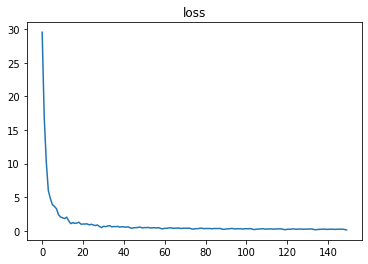

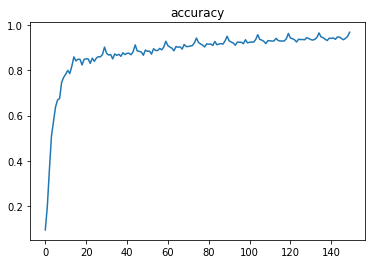

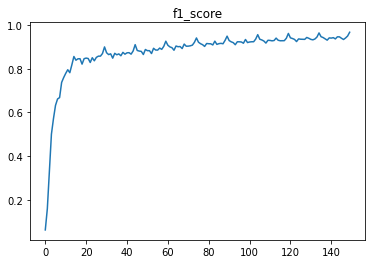

In [ ]:
for key, value in history_torch['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()

In [ ]:
history_torch['train']['loss'][0]

2.3177589988918044